## Data loading

In [ ]:
import numpy as np
import sys
from pathlib import Path

# Add the parent directory of the notebook to sys.path
parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))

from utils.metrics import create_kl_adjacency
from utils.internal_validation_metrics import manual_silhouette_score, manual_dbi, manual_modularity
from utils.graph_visualization import graph_viz, plot_spectral_clusters

In [ ]:
import pandas as pd
import pyarrow.parquet as pq
from IPython.display import display
# Read Parquet with PyArrow, keeping pandas metadata
table = pq.read_table("../data/sequence_dataset.parquet", use_pandas_metadata=True)
df = table.to_pandas()
display(df.head(5))

# Robust CTM stacking that unwraps singleton nesting and coerces to float array
def stack_ctm(entry):
    import ast

    e = entry
    # unwrap extra singleton nesting like [[...]] -> [...]
    while isinstance(e, (list, tuple)) and len(e) == 1:
        e = e[0]

    # if stored as a string, try to parse it
    if isinstance(e, str):
        e = ast.literal_eval(e)

    arr = np.array(e, dtype=object)

    # if object dtype, try to build numeric rows
    if arr.dtype == object:
        try:
            rows = [np.asarray(r, dtype=float) for r in arr]
            arr = np.vstack(rows)
        except Exception as exc:
            raise ValueError(f"Cannot convert CTM entry to numeric array: {exc}")

    # handle an extra leading singleton dimension (1,129,129)
    if arr.ndim == 3 and arr.shape[0] == 1 and arr.shape[1:] == (129, 129):
        arr = arr.squeeze(0)

    if arr.shape != (129, 129):
        raise ValueError(f"Unexpected CTM shape {arr.shape}; expected (129,129)")

    return arr.astype(float)

def normalize_global(M: np.ndarray) -> np.ndarray:
    total = M.sum()
    return M / total if total != 0 else M.astype(float)

# Apply conversion + normalization with index-aware errors for easier debugging
ctm_matrices = []
for i, e in enumerate(df["ctm"]):
    try:
        mat = stack_ctm(e)
        mat = normalize_global(mat)
        ctm_matrices.append(mat)
    except Exception as exc:
        raise ValueError(f"Error processing ctm at row {i}: {exc}")

df["ctm_matrix"] = ctm_matrices

# Quick verification
print("Rows:", len(df))
print("Example shape (row 0):", df.loc[0, "ctm_matrix"].shape)
print("Sum of example (row 0):", df.loc[0, "ctm_matrix"].sum())
# Optionally check that every matrix sums to 1 (or 0 if originally all zeros)
sums = df["ctm_matrix"].apply(np.sum)
print("Number of matrices with sum == 1:", (np.isclose(sums, 1.0)).sum())
print("Number of zero-sum matrices:", (sums == 0).sum())

,name,note_sequence,ctm,id,rating,themes,keywords,involved_companies,first_release_year
0,Star Wars: Rogue Squadron II - Rogue Leader,"[55, 55, 60, 60, 48, 48, 51, 51, 62, 62, 56, 5...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4181,85.4,"[""Action"", ""Science fiction""]","[""space simulation"", ""space combat"", ""robots"",...","[""Activision"", ""Factor 5"", ""LucasArts""]",2001
1,Star Wars: Rogue Squadron II - Rogue Leader,"[59, 38, 47, 47, 59, 47, 47, 38, 59, 47, 38, 4...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4181,85.4,"[""Action"", ""Science fiction""]","[""space simulation"", ""space combat"", ""robots"",...","[""Activision"", ""Factor 5"", ""LucasArts""]",2001
2,Donkey Kong Jungle Beat,"[45, 64, 61, 57, 64, 61, 57, 45, 57, 64, 61, 4...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1097,67.7,"[""Action""]","[""combat"", ""pig"", ""panda"", ""underwater gamepla...","[""Nintendo EAD Tokyo Software Development Grou...",2004
3,Donkey Kong Jungle Beat,"[70, 71, 72, 73, 42, 23, 49, 73, 61, 56, 49, 6...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1097,67.7,"[""Action""]","[""combat"", ""pig"", ""panda"", ""underwater gamepla...","[""Nintendo EAD Tokyo Software Development Grou...",2004
4,Viewtiful Joe,"[33, 33, 75, 81, 33, 36, 36, 36, 38, 38, 59, 3...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",341259,0,"[""Action""]",[],"[""Clover Studio"", ""Capcom""]",2004


Rows: 3320
Example shape (row 0): (129, 129)
Sum of example (row 0): 1.0
Number of matrices with sum == 1: 3320
Number of zero-sum matrices: 0


In [ ]:
p = Path("../data") / "ctms_distance_matrix.npy"

if p.exists():
    print("Distance matrix already exists; loading from file.")
    distance_matrix = np.load(p)
else:
    ctms_list = df['ctm_matrix'].tolist()
    distance_matrix = create_kl_adjacency(ctms_list)
    np.save(p, distance_matrix)

Distance matrix already exists; loading from file.


## Spectral clustering

### Distances to similarity

In [ ]:
import numpy as np

def distance_to_sparse_similarity_percentile(D: np.ndarray, sigma: float = None, percentile: float = 90) -> np.ndarray:
    """
    Convert distance matrix D to a sparse similarity matrix using a Gaussian kernel,
    keeping only similarities above the given percentile.
    
    Args:
        D: distance matrix (n x n)
        sigma: Gaussian kernel width; if None, use median of non-zero distances / 2
        percentile: keep only top `percentile` % similarities
    """
    if sigma is None:
        sigma = np.median(D[D > 0]) / 2
    
    S = np.exp(-D**2 / (2 * sigma**2))
    np.fill_diagonal(S, 0)

    # data-informed threshold
    thresh = np.percentile(S[S > 0], percentile)
    sparse_S = np.where(S >= thresh, S, 0)

    # make symmetric
    sparse_S = np.maximum(sparse_S, sparse_S.T)
    return sparse_S

S_sparse = distance_to_sparse_similarity_percentile(distance_matrix, percentile=80)
n = S_sparse.shape[0]

# minimal similarity to add (tiny positive value)
min_sim = 1e-6

for i in range(n):
    if S_sparse[i].sum() == 0:  # isolated node
        # find the strongest neighbor according to original distance
        j = np.argmax(distance_matrix[i] * (1 - np.eye(n)[i]))
        # instead of original Gaussian similarity, assign minimal value
        S_sparse[i, j] = min_sim
        S_sparse[j, i] = min_sim  # ensure symmetry

sim_matrix = np.maximum(S_sparse, S_sparse.T)

### Spectral Embedding + k-Means

In [ ]:
import pickle
from pathlib import Path
from scipy.linalg import fractional_matrix_power
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

# File to save/load clustering results
p_clusters = Path("../data/ctms_clusters.pkl")
k_values = range(2, 9)

if p_clusters.exists():
    print("Clustering results already exist; loading from file.")
    with open(p_clusters, "rb") as f:
        results = pickle.load(f)
    labels_all = results['labels_all']
    scores = results['silhouette_scores']
    dbi_scores = results['dbi_scores']
    mod_scores = results['modularity_scores']
    X_norm_all = results.get('X_norm_all', None)  # load if saved
else:
    from scipy.linalg import eigh

    # Compute Laplacian
    D = np.diag(sim_matrix.sum(axis=1))
    D_inv_sqrt = fractional_matrix_power(D, -0.5)
    L_sym = np.eye(sim_matrix.shape[0]) - D_inv_sqrt @ sim_matrix @ D_inv_sqrt

    scores = []
    dbi_scores = []
    mod_scores = []
    labels_all = {}     # store labels for each k
    X_norm_all = {}     # store normalized eigenvectors for each k

    for k in k_values:
        eigvals, eigvecs = eigh(L_sym)
        X = eigvecs[:, :k]
        X_norm = normalize(X, norm='l2', axis=1)
        X_norm_all[k] = X_norm  # save normalized vectors

        labels = KMeans(n_clusters=k, random_state=42).fit_predict(X_norm)
        labels_all[k] = labels

        # silhouette
        sill = manual_silhouette_score(X_norm, labels)
        scores.append(sill)

        # Davies–Bouldin Index (lower is better)
        dbi = manual_dbi(X_norm, labels)
        dbi_scores.append(dbi)

        # modularity
        mod = manual_modularity(sim_matrix, labels)
        mod_scores.append(mod)

    # save results including X_norm_all
    with open(p_clusters, "wb") as f:
        pickle.dump({
            'labels_all': labels_all,
            'silhouette_scores': scores,
            'dbi_scores': dbi_scores,
            'modularity_scores': mod_scores,
            'X_norm_all': X_norm_all
        }, f)

Clustering results already exist; loading from file.


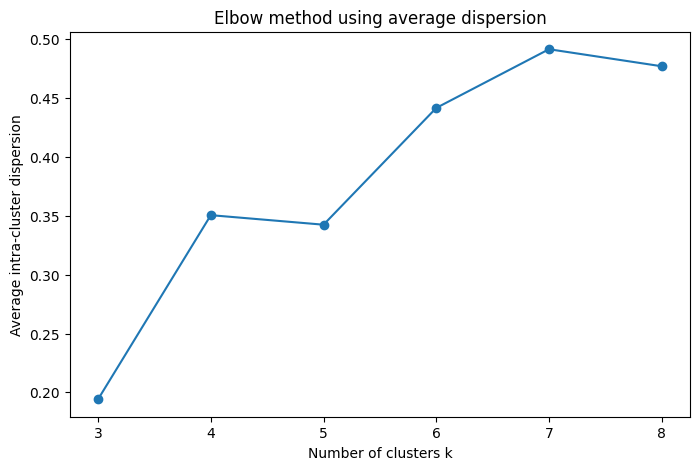

In [ ]:
import matplotlib.pyplot as plt

avg_dispersion = []

for k in k_values:
    X_norm = X_norm_all[k]
    labels = labels_all[k]
    dispersion = 0

    for cluster_id in range(k):
        cluster_points = X_norm[labels == cluster_id]  # boolean mask is valid now
        if len(cluster_points) > 1:
            centroid = cluster_points.mean(axis=0)
            dispersion += np.mean(np.linalg.norm(cluster_points - centroid, axis=1))

    dispersion /= k
    avg_dispersion.append(dispersion)

# Plot elbow w.r.t average dispersion
plt.figure(figsize=(8,5))
plt.plot(k_values[1:], avg_dispersion[1:], marker='o')
plt.xlabel('Number of clusters k')
plt.ylabel('Average intra-cluster dispersion')
plt.title('Elbow method using average dispersion')
plt.show()


### Pick best $k$

In [16]:
best_k = 7 # By Elbow method, see Figure above
best_labels = labels_all[best_k]
print("Best k by Elbow method:", best_k)
print(f"Silhouette score for k={best_k}: {manual_silhouette_score(X_norm, best_labels):.4f}")

Best k by Elbow method: 7
Silhouette score for k=7: 0.2776


In [17]:
# Ensure matrices_df exists (build from df if missing)
if 'matrices_df' not in globals():
    if 'ctm_matrix' in df.columns:
        matrices_df = df[['ctm_matrix']].rename(columns={'ctm_matrix': 'ctm'}).copy()
    elif 'ctm' in df.columns:
        matrices_df = df[['ctm']].copy()
    else:
        raise ValueError("Cannot build matrices_df: neither 'ctm_matrix' nor 'ctm' found in df.")
    matrices_df.index.name = 'song_idx'

# Choose labels: prefer best_labels, fall back to other globals if necessary
if 'best_labels' in globals():
    labels = best_labels
elif 'labels' in globals():
    labels = labels
elif 'labels_all' in globals() and 'best_k' in globals():
    labels = labels_all[best_k]
else:
    raise ValueError("No clustering labels found in globals (expected 'best_labels' or 'labels').")

# Ensure labels length matches matrices_df / sim_matrix
if len(labels) != sim_matrix.shape[0] or len(labels) != len(matrices_df):
    raise ValueError(f"Length mismatch: labels ({len(labels)}), sim_matrix ({sim_matrix.shape[0]}), matrices_df ({len(matrices_df)})")

# Order indices by cluster label
order = np.argsort(labels)
sim_ordered = sim_matrix[np.ix_(order, order)]

In [18]:
# get cluster labels from available globals
if 'labels' in globals():
    labels_arr = labels
elif 'best_labels' in globals():
    labels_arr = best_labels
elif 'labels_all' in globals() and 'best_k' in globals():
    labels_arr = labels_all[best_k]
else:
    raise ValueError("No cluster labels found in globals() (expected 'labels' or 'best_labels').")

# attach cluster column to matrices_df if missing or out-of-date
if 'cluster' not in matrices_df.columns or len(matrices_df) != len(labels_arr) or not np.array_equal(matrices_df['cluster'].to_numpy(), labels_arr):
    matrices_df['cluster'] = labels_arr

# determine number of clusters
k = int(labels_arr.max() + 1)

# helper to pick a suitable metadata field from the parquet df
def _game_for(idx):
    for c in ('game', 'videogame', 'id', 'name'):
        if c in df.columns:
            return df.loc[idx, c]
    return ""

for cluster_id in range(k):
    print(f"\nCluster {cluster_id + 1}:")
    # indices (positions in the parquet / df) belonging to this cluster
    song_indices = matrices_df[matrices_df['cluster'] == cluster_id].index

    # Build labels: "<song_idx> (<videogame or fallback>)"
    cluster_labels = [f"{int(idx)} ({_game_for(idx)})" for idx in song_indices]
    print(cluster_labels)


Cluster 1:
['3 (1097)', '7 (251979)', '42 (1204)', '43 (1204)', '53 (1204)', '58 (1204)', '105 (229177)', '108 (229177)', '120 (90109)', '159 (3492)', '178 (3492)', '182 (3403)', '234 (1627)', '273 (1627)', '313 (4167)', '335 (4156)', '400 (2655)', '411 (2655)', '416 (412)', '445 (1034)', '466 (1033)', '473 (1033)', '484 (1033)', '506 (1033)', '522 (1033)', '529 (1033)', '563 (1033)', '565 (1033)', '573 (192194)', '576 (192194)', '612 (317414)', '621 (3796)', '625 (176035)', '688 (15108)', '722 (1108)', '735 (254335)', '745 (1751)', '747 (1751)', '775 (3349)', '818 (5401)', '819 (5401)', '821 (5401)', '838 (4293)', '853 (5378)', '861 (4449)', '883 (1655)', '910 (2205)', '920 (118)', '942 (991)', '1003 (1037)', '1011 (1037)', '1021 (21055)', '1023 (1038)', '1025 (1038)', '1042 (1693)', '1048 (1693)', '1050 (23016)', '1057 (9585)', '1074 (1779)', '1075 (1779)', '1085 (1779)', '1087 (1779)', '1090 (1779)', '1102 (1779)', '1103 (1779)', '1106 (18600)', '1135 (2345)', '1153 (2345)', '1157 

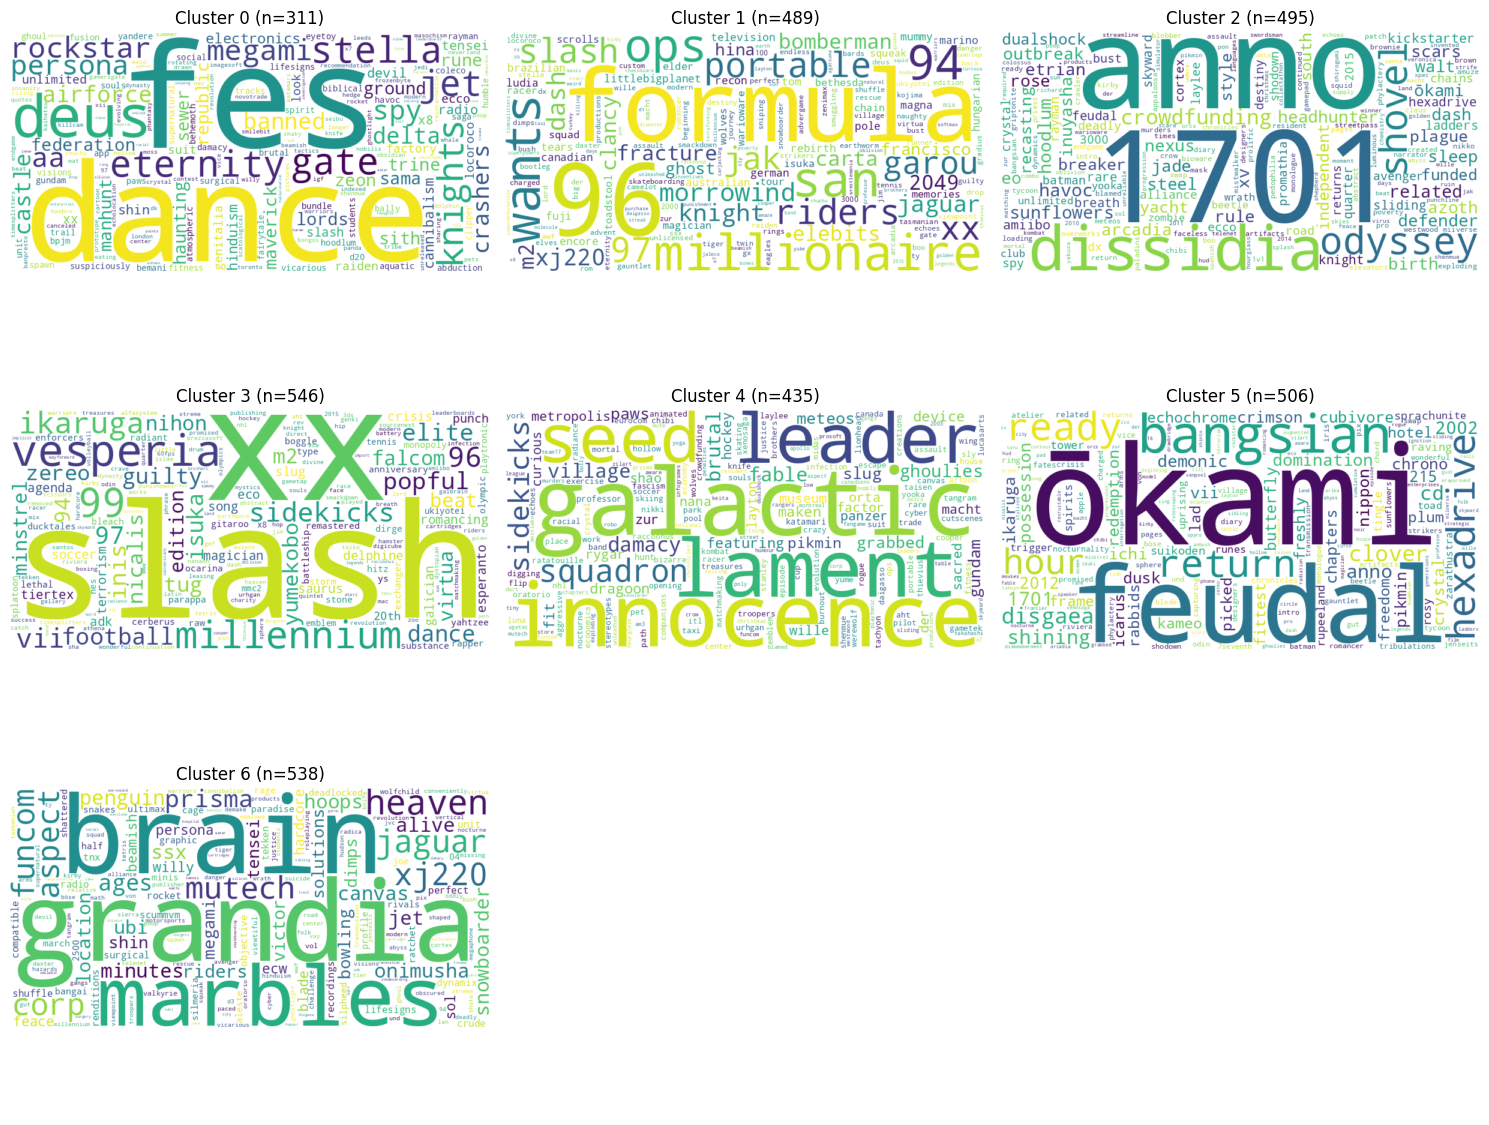

In [19]:
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Build metadata_df from parquet df and ensure cluster column is present
if 'matrices_df' in globals() and 'cluster' in matrices_df.columns:
    metadata_df = df.copy()
    # matrices_df.index are the song indices into df; align cluster by index
    metadata_df['cluster'] = matrices_df['cluster'].reindex(df.index).to_numpy()
else:
    raise ValueError("matrices_df with 'cluster' column is required in globals()")

# columns to merge
cols = ['name', 'keywords', 'themes', 'involved_companies']
cols = [c for c in cols if c in metadata_df.columns]
if not cols:
    raise ValueError("None of expected metadata columns found: name, keywords, themes, involved_companies")

def parse_list_field(x):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return []
    if isinstance(x, (list, tuple)):
        return [str(i) for i in x]
    if isinstance(x, str):
        s = x.strip()
        # try literal_eval for JSON-like lists
        try:
            val = ast.literal_eval(s)
            if isinstance(val, (list, tuple)):
                return [str(i) for i in val]
        except Exception:
            pass
        # fallback: remove brackets and split on commas
        s2 = s.strip("[]")
        parts = [p.strip().strip('"\'' ) for p in s2.split(",") if p.strip()]
        return parts
    return [str(x)]

# create combined text per song from the fields
def make_combined_text(row):
    toks = []
    for c in cols:
        toks.extend(parse_list_field(row.get(c, None)))
    # also include name if present for more context (optional)
    if 'name' in metadata_df.columns and pd.notna(row.get('name')):
        toks.append(str(row.get('name')))
    return " ".join([t.lower() for t in toks])

metadata_df['combined_text'] = metadata_df.apply(make_combined_text, axis=1)

# Fit TF-IDF on full corpus (only on combined fields)
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
vectorizer.fit(metadata_df['combined_text'].fillna(''))

# Prepare cluster texts
cluster_ids = sorted(metadata_df['cluster'].dropna().unique().astype(int))
n_clusters = len(cluster_ids)
cluster_texts = [
    " ".join(metadata_df[metadata_df['cluster'] == cid]['combined_text'].fillna(''))
    for cid in cluster_ids
]

# Compute TF-IDF per-cluster (treating each cluster as one "document")
tfidf_mat = vectorizer.transform(cluster_texts)  # shape (n_clusters, n_features)
# Count in how many clusters each term appears (cluster document frequency)
presence = (tfidf_mat > 0).astype(int).sum(axis=0)     # sparse -> matrix
cluster_df = np.asarray(presence).ravel()            # array of length n_features

# Cluster-level IDF-like weight to penalize terms that appear across many clusters
# If a term appears in all clusters, weight -> log((n+1)/(n+1)) = 0 (fully penalized)
cluster_idf = np.log((n_clusters + 1.0) / (cluster_df + 1.0))

# Apply the cluster-level penalty to per-cluster TF-IDF scores
adjusted = tfidf_mat.toarray() * cluster_idf[np.newaxis, :]  # shape (n_clusters, n_features)

# Optionally, you can also subtract a small fraction of the global mean to further demote very common tokens:
# alpha = 0.0  # set to e.g. 0.5 to be more aggressive
# global_mean = adjusted.mean(axis=0)
# adjusted = np.maximum(0.0, adjusted - alpha * global_mean[np.newaxis, :])

words = vectorizer.get_feature_names_out()

# layout for plotting
n_cols = math.ceil(math.sqrt(n_clusters))
n_rows = math.ceil(n_clusters / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = np.array(axes).flatten()

for i, cid in enumerate(cluster_ids):
    row_scores = adjusted[i]
    # build dict of positive scores only (penalized common terms will be near-zero)
    word_scores = {w: float(s) for w, s in zip(words, row_scores) if s > 0.0}
    if not word_scores:
        axes[i].axis('off')
        continue

    wc = WordCloud(width=800, height=400, background_color='white')
    wc.generate_from_frequencies(word_scores)

    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f"Cluster {cid} (n={len(metadata_df[metadata_df['cluster']==cid])})", fontsize=12)

# hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

**(Adapted layout for 7 clusters below)**

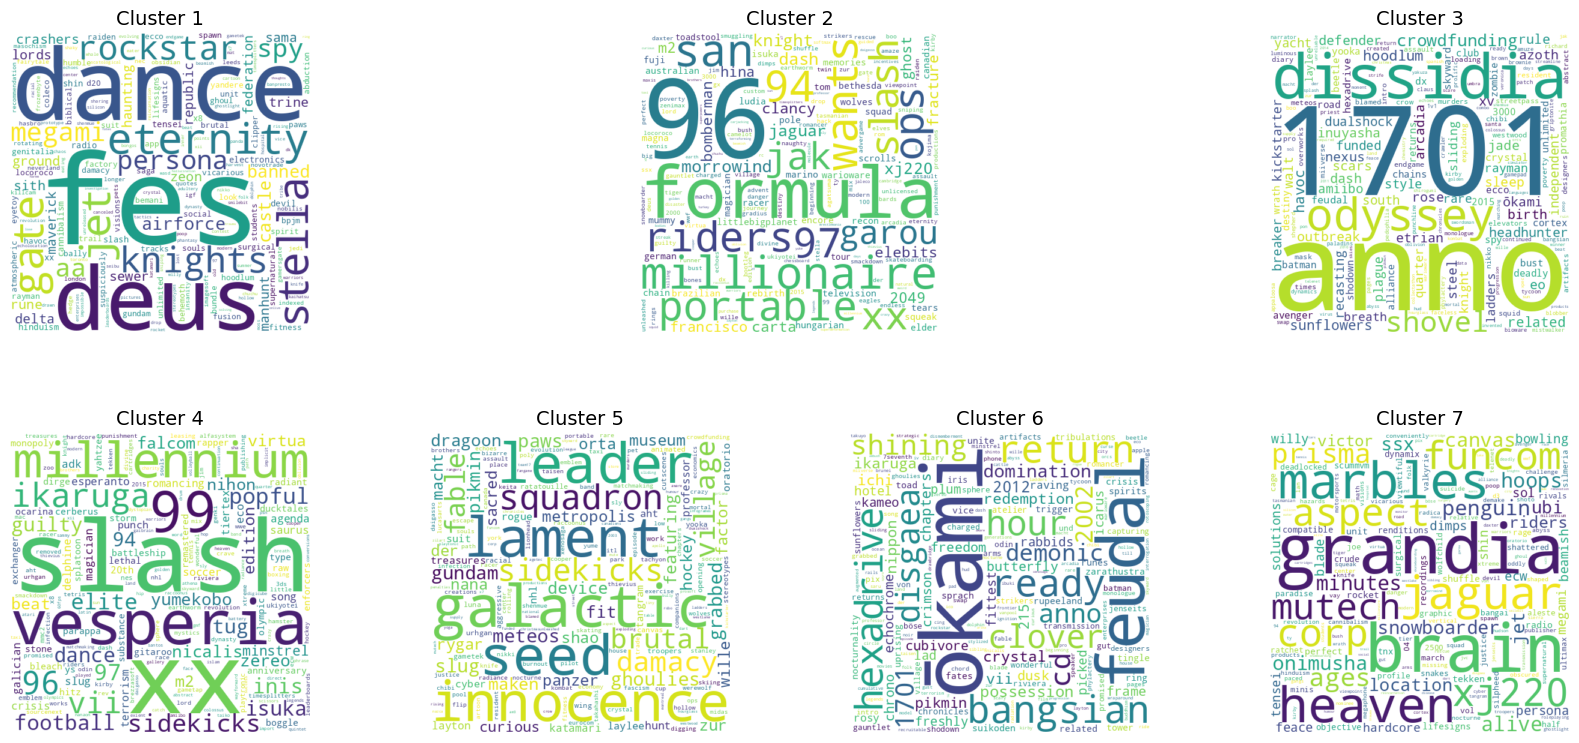

In [20]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

# Example data
cluster_ids = list(range(7))

fig = plt.figure(figsize=(14, 10))  # larger figure

# Define rows: (number of clusters in row, y-position)
rows = [
    (3, 0.65),  # top row
    (4, 0.25)   # bottom row
]

idx = 0
for n_in_row, y_pos in rows:
    # Evenly spaced x positions from 0.05 to 0.95 for better margins
    x_positions = np.linspace(0.05, 0.95, n_in_row)
    for x_pos in x_positions:
        if idx >= len(cluster_ids):
            break
        cid = cluster_ids[idx]

        # Prepare WordCloud for this cluster
        row_scores = adjusted[cid]
        word_scores = {w: float(s) for w, s in zip(words, row_scores) if s > 0.0}
        if not word_scores:
            idx += 1
            continue

        wc = WordCloud(width=500, height=500, background_color='white')  # bigger clouds
        wc.generate_from_frequencies(word_scores)

        # Increase subplot size (width, height) for bigger clouds
        ax = fig.add_axes([x_pos - 0.15, y_pos - 0.15, 0.3, 0.3])  # wider and taller
        ax.imshow(wc, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f"Cluster {cid+1}", fontsize=14)

        idx += 1

plt.show()

In [22]:
plot_spectral_clusters(sim_matrix, labels_arr, show_edges=False, edge_percentile=90)